In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Other imports
import mavenn
import logomaker
import re
import suftware   

# Import custom utility functions
from utils import get_one_hot_encoding, \
                  evaluate_pairwise_model, \
                  evaluate_additive_model, \
                  fix_pairwise_model_gauge

data_dir = '../data/'
out_dir = '../output/'
fig_name='fig_1.4_gb1params'
train_model = True  # Set equal to True to train GB1 pairwise model using MAVE-NN

%matplotlib inline

In [2]:
# Make sure I'm running local mavenn
mavenn.__file__

'/Users/jkinney/github/mavenn/mavenn/__init__.py'

In [3]:
# Create style file
style_file_name = f'{out_dir}{fig_name}.style'
s = """
    axes.linewidth:     0.5     # edge linewidth
    font.size:          7.0
    axes.titlesize:     7.0
    axes.labelsize:     7.0  # fontsize of the x any y labels
    xtick.labelsize:    7.0  # fontsize of the tick labels
    ytick.labelsize:    7.0  # fontsize of the tick labels
    legend.fontsize:      7.0
    legend.borderpad:     0.2  # border whitespace
    legend.labelspacing:  0.2  # the vertical space between the legend entries
    legend.borderaxespad: 0.2  # the border between the axes and legend edge
    legend.framealpha:    1.0 
    xtick.major.size:    2 
    ytick.major.size:    2
    """
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [4]:
r_df = pd.read_csv(f'{data_dir}Wu-2016-measurements.csv',
                   usecols=[0,2,3],
                   names=['sequence','inputCount','outputCount'], skiprows=1)
r_df

,sequence,inputCount,outputCount
0,VDGV,92735,338346
1,ADGV,34,43
2,CDGV,850,641
3,DDGV,63,63
4,EDGV,841,190
...,...,...,...
149356,YYYR,203,1
149357,YYYS,186,3
149358,YYYT,181,14
149359,YYYW,30,1


In [5]:
# Load data from excel sheet
#r_df = pd.read_excel(f'{data_dir}Wu-2016-measurements.xlsx',usecols=[0,2,3],names=['sequence','inputCount','outputCount'])
wtInputCount=r_df.iloc[0,1] + 1
wtOutputCount=r_df.iloc[0,2] + 1
wtFitness=wtOutputCount/wtInputCount
r_df['relativeFitness'] = ((r_df['outputCount']+1) /(r_df['inputCount']+1)) / wtFitness
r_df['logRelativeFitness']=np.log(r_df['relativeFitness'])
r_df

,sequence,inputCount,outputCount,relativeFitness,logRelativeFitness
0,VDGV,92735,338346,1.000000,0.000000
1,ADGV,34,43,0.344565,-1.065474
2,CDGV,850,641,0.206772,-1.576139
3,DDGV,63,63,0.274085,-1.294315
4,EDGV,841,190,0.062174,-2.777822
...,...,...,...,...,...
149356,YYYR,203,1,0.002687,-5.919288
149357,YYYS,186,3,0.005863,-5.139130
149358,YYYT,181,14,0.022589,-3.790272
149359,YYYW,30,1,0.017683,-4.035155


In [6]:
# Build data_df
data_df = pd.DataFrame()
data_df['set'] = np.random.choice(a=['training','validation','test'], 
                                  size=len(r_df), 
                                  p=[.9, .1, 0])
data_df['y'] = r_df['logRelativeFitness'].copy()
data_df['x'] = r_df['sequence'].copy()
data_df.head()

,set,y,x
0,training,0.000000,VDGV
1,training,-1.065474,ADGV
2,training,-1.576139,CDGV
3,training,-1.294315,DDGV
4,training,-2.777822,EDGV


In [7]:
# Define sequence sets
seqset_patterns = ['....', '..G.', '..[FL]G', '..[AC]A']
seqset_cols = [f'set_{i}' for i in range(4)]

# Mark which sequences are in each sequence set
for col, pattern in zip(seqset_cols, seqset_patterns):
    data_df[col] = [bool(re.match(pattern, x)) for x in data_df['x'].values]

data_df.head()

,set,y,x,set_0,set_1,set_2,set_3
0,training,0.000000,VDGV,True,True,False,False
1,training,-1.065474,ADGV,True,True,False,False
2,training,-1.576139,CDGV,True,True,False,False
3,training,-1.294315,DDGV,True,True,False,False
4,training,-2.777822,EDGV,True,True,False,False


In [8]:
# Alphabet from Wu et al., 2016
alphabet = list('EDRKHQNSTPGCAVILMFYW')

if train_model:

    # Fit pairwise model using mavenn
    model = mavenn.Model(L=4,
                         alphabet=alphabet, #'protein',
                         regression_type='GE',
                         gpmap_type='pairwise',
                         ge_nonlinearity_type='linear',
                         ge_noise_model_type='Gaussian',
                         ge_heteroskedasticity_order=0)

    model.set_data(x=data_df['x'],
                   y=data_df['y'],
                   validation_flags=data_df['set']=='validation')

    model.fit(try_tqdm=True, verbose=True, epochs=10, linear_initialization=True)

    model.save(f'{out_dir}gb1_pairwise_model')

N = 149,361 observations set as training data.
Using 10.0% for validation.
Data shuffled.
Time to set data: 0.508 sec.


0epoch [00:00, ?epoch/s]

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 134379 rows and 80 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       80

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.662e+02  2.094e+04   1.0e+00  1.6e-01
     1  1.06791e-02  2.645e+02  1.496e+03   7.2e-01  6.8e-02  8.3e+01  1.0e+00
     2  1.43676e-02  2.642e+02  1.130e+03   7.2e-01  3.5e-02  1.2e+02  1.1e+00
     3  1.28777e-02  2.635e+02  5.788e+02   7.2e-01  1.1e-02  1.9e+02  2.1e+00
     4  1.49816e-02  2.632e+02  3.030e+02   7.2e-01  5.7e-03  2.0e+02  2.9e+00
     5  1.95663e-02  2.632e+02  2.521e+01   7.2e-01  4.4e-04  2.2e+02  2.5e+00
     6  1.99980e-02  2.632e+02  1.095e+00   7.2e-01  1.8e-05  2.3e+02  2.5e+00
     7  2.00182e-02  2.632e+02  4.761e-02   7.2e-01  7.4e-07  2.5e+02  2.5e+00
 
LSMR finished
The least-squares solution is good enough, given atol     
istop

In [9]:
# Load pairwise model and remove diffeomoprhic mode fixing
model = mavenn.load(f'{out_dir}gb1_pairwise_model')

# Plot p_lc for different choices of sequenc
alphabet = model.alphabet
L = model.L
C = len(alphabet)
alphabet

Model loaded from these files:
	../output/gb1_pairwise_model.pickle
	../output/gb1_pairwise_model.h5


array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

In [10]:
# Set probability distributions for different regions

# region 0: '****'
p0_df = pd.DataFrame(index=range(L), columns=alphabet, data=1/C) \

# region 1: '**G*'
p1_df = p0_df.copy()
p1_df.loc[2,:] = np.isin(alphabet, ['G']).astype(float)

# region 2: '**[FL]G'
p2_df = p0_df.copy()
p2_df.loc[2,:] = np.isin(alphabet, ['F','L']).astype(float)/2
p2_df.loc[3,:] = np.isin(alphabet, ['G']).astype(float)

# region 3: '**[AC]A'
p3_df = p0_df.copy()
p3_df.loc[2,:] = np.isin(alphabet, ['A','C']).astype(float)/2
p3_df.loc[3,:] = np.isin(alphabet, ['A']).astype(float)

seqset_p_dfs = [p0_df, p1_df, p2_df, p3_df]

# Multiply by small numbers to rank in alphabetical order
alphabetical_order = np.tile(1 - (1E-4)*np.arange(C)/C, [4,1])
for p_df in seqset_p_dfs:
    p_df.loc[:,:] = p_df.values * alphabetical_order
    p_df.loc[:,:] = p_df.values / p_df.values.sum(axis=1)[:,np.newaxis]

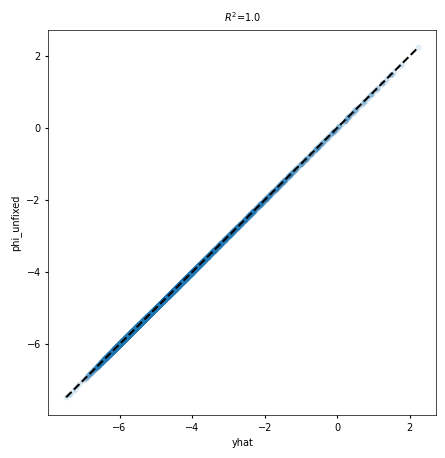

In [11]:
# Get unfixed parameters, shifted and rescaled to match model predictions
# Note: this is way more complicated that it should be
phi_to_r_scale = model.phi_to_yhat(1) - model.phi_to_yhat(0)
phi_to_r_shift = model.phi_to_yhat(0)

d = model.get_theta(gauge='none')

theta_dict_unfixed = {}
theta_dict_unfixed['theta_0'] = phi_to_r_shift + \
    (phi_to_r_scale/model.unfixed_phi_std)*(d['theta_0']-model.unfixed_phi_mean)
theta_dict_unfixed['theta_lc'] = (phi_to_r_scale/model.unfixed_phi_std)*d['theta_lc']
theta_dict_unfixed['theta_lclc'] = (phi_to_r_scale/model.unfixed_phi_std)*d['theta_lclc']

# Get subset of sequences
x = data_df['x']
x_sub = np.random.choice(x, size=5000, replace=False)
x_ohe_sub = get_one_hot_encoding(x=x_sub, alphabet=model.alphabet)

# Compute yhat predictions using mavenn model
yhat = model.x_to_yhat(x_sub)

# Compute phi predictions using adjusted parameters
phi_unfixed = evaluate_pairwise_model(theta_dict_unfixed, x_ohe_sub).ravel()

# Verify that this matches model predictions
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Compare yhat and phi_unfixed
Rsq = np.corrcoef(yhat, phi_unfixed)[0, 1]**2
ax.scatter(yhat, phi_unfixed, color='C0', s=10, alpha=.1,
           label='test data',
           rasterized=True)
xlim = [min(yhat), max(yhat)]
ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.set_xlabel('yhat')
ax.set_ylabel('phi_unfixed')
ax.set_title(f'$R^2$={Rsq:.3}');

/var/folders/20/m6rbxnjn0zq40r2bn1x6f5x80000gn/T/ipykernel_10042/1963558385.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=1, pad=2)


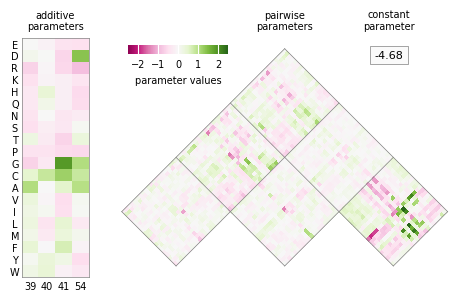

In [12]:
# Make big panel showing uniformly fixed model
fig= plt.figure(figsize=[5,3.2])
#fig= plt.figure(figsize=[15,9])

position_labels = ['39', '40', '41', '54']

p_lc_uniform = seqset_p_dfs[0].values
clim = [-2.5,2.5]
gs = gridspec.GridSpec(1, 6, figure=fig)

# Gauge-fix model parameters
theta_dict_fixed = fix_pairwise_model_gauge(theta_dict=theta_dict_unfixed,
                                            p_lc=p_lc_uniform)
    
theta_lc = theta_dict_fixed['theta_lc']
ax = fig.add_subplot(gs[0, 0])
ax, cb = mavenn.heatmap(values=theta_lc,
                        alphabet=alphabet, #'protein',
                        ccenter=0,
                        cmap='PiYG',
                        ax=ax,
                        clim=clim,
                        cbar=False)

for spine in ax.spines.values():
    spine.set(visible='True', color='gray') 

# dot_coords_list = [
#     [(2,'G')],
#     [(2,'L'), (2,'F'), (3,'G')],
#     [(2,'A'), (2,'C'), (3,'A')],
# ]
    
# #draw dots
# dot_coords = [(0,'V'), (1,'D'), (2,'G'), (3,'V')]
# for p,c in dot_coords:
#     c_loc = np.where(alphabet==c)[0][0]
#     ax.scatter(p, c_loc, color='k', s=3)
    
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(position_labels, ha='center')
ax.tick_params(axis='both', which='major', size=0, pad=5)
ax.tick_params(axis='x', which='major', pad=3)

#ax.set_xlabel('position')
ax.set_title(f'additive\nparameters')
#ax.set_ylabel('symmetric gauge\nparameters', labelpad=5)

ax = fig.add_subplot(gs[0, 1:])
ax, cb = mavenn.heatmap_pairwise(values=theta_dict_fixed['theta_lclc'],
                        alphabet=alphabet, #'protein',
                        show_alphabet=False,
                        alphabet_size=4,
                        cmap='PiYG',
                        #alphabet_size=8,
                        clim=clim,
                        ax=ax,
                        cbar=False)
ax.patch.set_alpha(0.0)
ax.set_title(f'pairwise\nparameters')
#ax.set_xlabel('position')
ax.set_xticks([])
#ax.set_xticks([0,1,2,3])
#ax.set_xticklabels(position_labels, fontsize=6)

cbar_ax = fig.add_axes([0.275, 0.80, 0.2, 0.03])
im = ax.collections[0]
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.outline.set_visible(False)
cb.set_ticks([-2, -1, 0, 1, 2])
cb.set_label('parameter values', fontsize=7)
cbar_ax.tick_params(axis='x', direction='in', color='white', size=10)

# Draw theta0
theta0 = theta_dict_fixed["theta_0"]
xmax = ax.get_xlim()[-1]
xrange = np.diff(ax.get_xlim())[0]
ymax = ax.get_ylim()[-1]
yrange = np.diff(ax.get_xlim())[0]
x = xmax-.2*xrange
y1 = ymax+.02*yrange
y2 = ymax-.05*yrange
ax.text(s='constant\nparameter', x=x, y=y1, ha='center', va='bottom')
lightgray=[.98, .98, .98]
ax.text(s=f'{theta0:.2f}', x=x, y=y2, ha='center', va='center', fontsize=8,
       bbox=dict(facecolor=lightgray, edgecolor='gray', pad=3, linewidth=.5))

fig.tight_layout(w_pad=1, pad=2)
fig.savefig(f'{out_dir}{fig_name}_C_ipynb.pdf')

In [13]:
loc = lambda c: np.where(alphabet==c)[0][0]
theta_0 = theta_dict_fixed['theta_0']
theta_lc = theta_dict_fixed['theta_lc']
theta_lclc = theta_dict_fixed['theta_lclc']

print(f'constant: {theta_0:.2f}')
print(f'additive, G41: {theta_lc[0, loc("V")]:.2f}')
print(f'additive, G41: {theta_lc[1, loc("D")]:.2f}')
print(f'additive, G41: {theta_lc[2, loc("G")]:.2f}')
print(f'additive, G41: {theta_lc[3, loc("V")]:.2f}')
print(f'pairwise, V39G41: {theta_lclc[0, loc("V"), 2, loc("G")]:.2f}')
print(f'pairwise, D40G41: {theta_lclc[1, loc("D"), 2, loc("G")]:.2f}')
print(f'pairwise, G41V54: {theta_lclc[2, loc("G"), 3, loc("V")]:.2f}')
print(f'pairwise, V39D40: {theta_lclc[0, loc("V"), 1, loc("D")]:.2f}')
print(f'pairwise, V39V54: {theta_lclc[0, loc("V"), 3, loc("V")]:.2f}')
print(f'pairwise, D40V54: {theta_lclc[1, loc("D"), 3, loc("V")]:.2f}')

print('Total additive score')
print(#theta_0 + \
    theta_lc[0, loc("V")] +\
    theta_lc[1, loc("D")] +\
    theta_lc[2, loc("G")] +\
    theta_lc[3, loc("V")])

print('Total pairwise score')
print(theta_0 + \
    theta_lc[0, loc("V")] +\
    theta_lc[1, loc("D")] +\
    theta_lc[2, loc("G")] +\
    theta_lc[3, loc("V")] +\
    theta_lclc[0, loc("V"), 1, loc("D")] +\
    theta_lclc[0, loc("V"), 2, loc("G")] +\
    theta_lclc[0, loc("V"), 3, loc("V")] +\
    theta_lclc[1, loc("D"), 2, loc("G")] +\
    theta_lclc[1, loc("D"), 3, loc("V")] +\
    theta_lclc[2, loc("G"), 3, loc("V")] )

constant: -4.68
additive, G41: 0.34
additive, G41: 0.04
additive, G41: 1.90
additive, G41: 0.10
pairwise, V39G41: 0.85
pairwise, D40G41: -0.53
pairwise, G41V54: 1.27
pairwise, V39D40: 0.36
pairwise, V39V54: 0.32
pairwise, D40V54: -0.11
Total additive score
2.3817660432725027
Total pairwise score
-0.1470314522869871


In [14]:
# Rank pairwise parameters in 41, 54 in terms of their magnitude.
feature_dict = {}
positions = [39, 40, 41, 54]
for p1 in range(L):
    for p2 in range(L):
        for c1 in alphabet:
            for c2 in alphabet:
                val = theta_lclc[p1, loc(c1), p2, loc(c2)]
                key = f'{c1}{positions[p1]}{c2}{positions[p2]}'
                if np.isfinite(val):
                    feature_dict[key] = val
                    
feature_df = pd.DataFrame(index=feature_dict.keys(), data=feature_dict.values(), columns=['value'])
feature_df.index.name = 'feature'
feature_df['abs'] = np.abs(feature_df['value'])
feature_df.sort_values(by='abs', inplace=True, ascending=False)
feature_df.reset_index(inplace=True)

feature_df['region1'] = ['G41' in key for key in feature_df['feature']]

feature_df['region2'] = [('G54' in key) & (('L41' in key) | ('F41' in key)) for key in feature_df['feature']]

feature_df['region3'] = [('A54' in key) & (('A41' in key) | ('C41' in key)) for key in feature_df['feature']]

feature_df['any_region'] = feature_df['region1'] | feature_df['region2'] | feature_df['region3']

feature_df['my region'] = [('G41' in key) | ('C41' in key) | ('A41' in key) | ('L41' in key) | ('F41' in key) \
                            | ('G54' in key) | ('A54' in key) for key in feature_df['feature']]

feature_df[:40]

,feature,value,abs,region1,region2,region3,any_region,my region
0,C41A54,2.638394,2.638394,False,False,True,True,True
1,L41G54,2.569099,2.569099,False,True,False,True,True
2,F41G54,2.272826,2.272826,False,True,False,True,True
3,A41A54,2.166827,2.166827,False,False,True,True,True
4,G41M54,2.118685,2.118685,True,False,False,True,True
5,L41T54,2.080014,2.080014,False,False,False,False,True
6,G41D54,-1.932252,1.932252,True,False,False,True,True
7,G41L54,1.862438,1.862438,True,False,False,True,True
8,F41T54,1.851824,1.851824,False,False,False,False,True
9,G41R54,-1.782069,1.782069,True,False,False,True,True


In [15]:
data_df['r'] = model.x_to_yhat(data_df['x'])
data_df.head()

,set,y,x,set_0,set_1,set_2,set_3,r
0,training,0.000000,VDGV,True,True,False,False,-0.147032
1,training,-1.065474,ADGV,True,True,False,False,-1.912484
2,training,-1.576139,CDGV,True,True,False,False,-1.546692
3,training,-1.294315,DDGV,True,True,False,False,-3.067342
4,training,-2.777822,EDGV,True,True,False,False,-3.077942


<y> = -4.78
1/2^<y> = 27.4


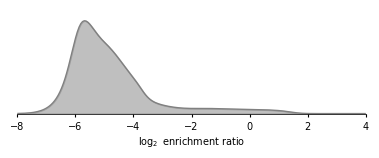

In [16]:
y_vals = data_df['y'].values
y_density = suftware.DensityEstimator(y_vals, bounding_box = [-8, 4], num_grid_points=200)
print(f'<y> = {y_vals.mean():.2f}')   
print(f'1/2^<y> = {2**(-y_vals.mean()):.1f}')


fig, ax = plt.subplots(1,1,figsize=[3.8,1.6])

# Plot distribution
x = y_density.grid

# Plot measurements
y = y_density.evaluate(x)
ax.fill_between(x, y, alpha=.5, color='gray')
ax.plot(x, y, color='gray', linewidth=1, label='y')

#y = r_density.evaluate(x)
#ax.plot(x, y, color='C1', linewidth=1, label='r')

ax.set_ylim([0,.5])
ax.set_xlim([-8, 3])
ax.set_yticks([])
ax.set_xticks([-8, -6, -4, -2, 0, 2, 4])
ax.set_xlabel('$\log_2$ enrichment ratio', labelpad=2)
for key, spine in ax.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
#ax.axvline(0, linewidth=.5, linestyle='-', color='k')
#ax.axvline(y_vals.mean(), linewidth=.5, linestyle='--', color='k')
#ax.legend()
    
fig.tight_layout()
fig.savefig(f'{out_dir}{fig_name}_B_ipynb.pdf')

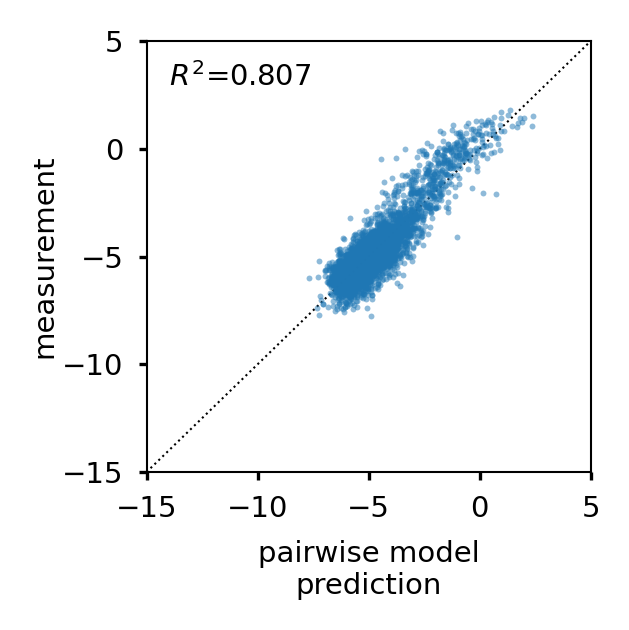

In [17]:
# Plot model predictions vs. measurements
fig, ax = plt.subplots(1,1,figsize=[1.9,1.9], dpi=300)

# Get subset of sequences
ix_sub = np.random.choice(len(data_df), size=5000, replace=False)
x_sub = data_df['x'][ix_sub].values.ravel()
y_sub = data_df['y'][ix_sub].values.ravel()

# Compute unfixed phi
x_ohe_sub = get_one_hot_encoding(x=x_sub, alphabet=model.alphabet)

# Get data to plot
phi_sub = evaluate_pairwise_model(theta_dict_unfixed, x_ohe_sub).ravel()

Rsq = np.corrcoef(phi_sub, y_sub)[0, 1]**2
ax.scatter(phi_sub, y_sub, color='C0', 
           s=2, alpha=.5,
           linewidth=0,
           rasterized=True)
lim = [-15, 5]
ticks = [-15, -10, -5, 0, 5]
ax.plot(lim, lim, ':', color='k', label='diagonal', zorder=-100, linewidth=.5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel('pairwise model\nprediction')
ax.set_ylabel('measurement', labelpad=1)
ax.text(x=-14, y=4, s=f'$R^2$={Rsq:.3}', ha='left', va='top');
fig.tight_layout(pad=0)
fig.savefig(f'{out_dir}{fig_name}_S1_ipynb.pdf')

In [18]:
# # Create figure
# fig, axs = plt.subplots(1,3,figsize=[1.8,.7])
# axs = axs.ravel()

# # Draw logos
# for i, p_df in enumerate(seqset_p_dfs[1:]):
#     ax = axs[i]
#     logomaker.Logo(p_df,
#                    vpad=0.02,
#                    ax=ax, 
#                    color_scheme='dimgray',
#                    font_name='Arial Rounded MT Bold',
#                    baseline_width=0,
#                    show_spines=False)
#     ax.set_yticks([])
#     ax.set_xticks([0,1,2,3])
#     ax.set_xticklabels(position_labels, fontsize=6, rotation=0)
#     ax.tick_params(axis='x', size=0)
#     ax.set_title(f'region {i+1}', pad=5)
    
# fig.tight_layout(pad=0, w_pad=1)
# fig.savefig(f'{fig_name}_C_ipynb.pdf')

In [19]:
# # Create figure
# # fig, axs = plt.subplots(1,4,figsize=[3.3,.7])
# # axs = axs.ravel()

# colors = ['C0', 'C1', 'C2', 'C3']

# seqsets = [
#     'global',
#     'region 1',
#     'region 2',
#     'region 3'
# ]

# # # Draw logos
# # for i, p_df in enumerate(seqset_p_dfs):
# #     ax = axs[i]
# #     logomaker.Logo(p_df,
# #                    vpad=0.02,
# #                    ax=ax, 
# #                    color_scheme=colors[i],
# #                    font_name='Arial Rounded MT Bold',
# #                    baseline_width=0,
# #                    show_spines=False)
# #     ax.set_yticks([])
# #     ax.set_xticks([0,1,2,3])
# #     ax.set_xticklabels(position_labels, fontsize=6, rotation=0)
# #     ax.tick_params(axis='x', size=0)
# #     ax.set_title(seqsets[i], pad=5)
    
# # fig.tight_layout(pad=0, w_pad=1)
# # fig.savefig(f'{fig_name}_D_ipynb.pdf')

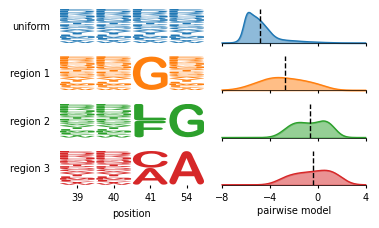

In [20]:
densities = []
for i in range(4):
    col = f'set_{i}'
    ix = data_df[col]
    r = data_df['r']
    density = suftware.DensityEstimator(r[ix].values, bounding_box = [-8, 4], num_grid_points=200)
    density.r_mean = r[ix].mean()
    densities.append(density)

colors = ['C0', 'C1', 'C2', 'C3']
 
seqsets = [
    'uniform',
    'region 1',
    'region 2',
    'region 3'
]
    
fig = plt.figure(figsize=[3.8,2.3])
gs = gridspec.GridSpec(4, 2, figure=fig)

for i in range(4):
    
    # Plot logo
    ax = fig.add_subplot(gs[i, 0])
    logomaker.Logo(seqset_p_dfs[i],
                   vpad=0.02,
                   ax=ax, 
                   color_scheme=colors[i],
                   font_name='Arial Rounded MT Bold',
                   baseline_width=0,
                   show_spines=False)
    ax.set_yticks([])
    if i==3:
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(position_labels, fontsize=7, rotation=0)
        ax.set_xlabel('position')
    else:
        ax.set_xticks([])
    #ax.tick_params(axis='x', size=0)
    ax.set_ylabel(seqsets[i], labelpad=5, rotation=0, ha='right', fontweight='regular', va='center')
    
    # Plot distribution
    ax = fig.add_subplot(gs[i, 1])
    x = densities[i].grid
    y = densities[i].evaluate(x)
    ax.fill_between(x,y,alpha=.5, color=colors[i], clip_on=False)
    ax.plot(x,y,color=colors[i], linewidth=1, clip_on=False)
    ax.axvline(densities[i].r_mean, linewidth=1, linestyle='--', color='k')
    ax.set_ylim([0,.5])
    ax.set_xlim([-8, 3])
    ax.set_yticks([])
    ax.set_xticks([-8, -4, 0, 4])
    if i==3:
        ax.set_xlabel('pairwise model', labelpad=2)
        #ax.set_xlabel('$\log_2$ enrichment ratio', labelpad=2)
    else:
        ax.set_xticklabels([])
    for key, spine in ax.spines.items():
        if key != 'bottom':
            spine.set_visible(False)
    
fig.tight_layout()
fig.savefig(f'{out_dir}{fig_name}_D_ipynb.pdf')

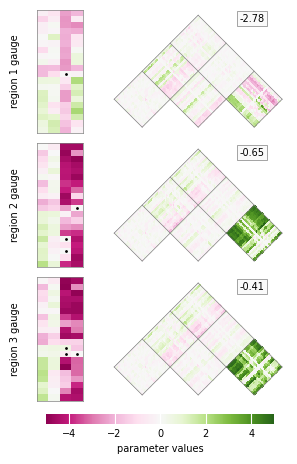

In [21]:
#fig= plt.figure(figsize=[3,4])
fig= plt.figure(figsize=[3.8,4.6])

gs = gridspec.GridSpec(3, 6, figure=fig)

clim=[-5,5]

dot_coords_list = [
    [(2,'G')],
    [(2,'L'), (2,'F'), (3,'G')],
    [(2,'A'), (2,'C'), (3,'A')],
]

for i, p_df in enumerate(seqset_p_dfs[1:]):
    
    # Gauge-fix model parameters
    theta_dict_fixed = fix_pairwise_model_gauge(theta_dict=theta_dict_unfixed,
                                                p_lc=p_df.values)
    
    theta_lc = theta_dict_fixed['theta_lc']
    ax = fig.add_subplot(gs[i, 0])
    ax, cb = mavenn.heatmap(values=theta_lc,
                            alphabet='protein',
                            ccenter=0,
                            cmap='PiYG',
                            ax=ax,
                            clim=clim,
                            cbar=None)
    ax.set_ylabel(f'region {i+1} gauge', labelpad=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set(visible='True', color='gray') 
    
    #draw dots
    for p,c in dot_coords_list[i]:
        c_loc = np.where(alphabet==c)[0][0]
        ax.scatter(p, c_loc, color='k', s=1)
    
    ax = fig.add_subplot(gs[i, 1:-1])
    mavenn.heatmap_pairwise(values=theta_dict_fixed['theta_lclc'],
                            alphabet='protein',
                            show_alphabet=False,
                            clim=clim,
                            cmap='PiYG',
                            cbar=False,
                            ax=ax)
    ax.patch.set_alpha(0.0)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw theta0
    theta0 = theta_dict_fixed["theta_0"]
    xmax = ax.get_xlim()[-1]
    xrange = np.diff(ax.get_xlim())[0]
    ymax = ax.get_ylim()[-1]
    yrange = np.diff(ax.get_xlim())[0]
    x = xmax-.2*xrange
    y1 = ymax+.02*yrange
    y2 = ymax-.05*yrange
    #ax.text(s='constant\nparameter', x=x, y=y1, ha='center', va='bottom')
    lightgray=[.98, .98, .98]
    ax.text(s=f'{theta0:.2f}', x=x, y=y2, ha='center', va='center', fontsize=7,
       bbox=dict(facecolor=lightgray, edgecolor='gray', pad=2, linewidth=.5))
    
fig.tight_layout(w_pad=1, h_pad=1, pad=0)

fig.subplots_adjust(bottom=0.15, left=.15)
cbar_ax = fig.add_axes([0.175, 0.10, 0.6, 0.02])
im = ax.collections[0]
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.outline.set_visible(False)
cb.set_ticks([-4, -2, 0, 2, 4])
cb.set_label('parameter values', fontsize=7)
cbar_ax.tick_params(axis='x', direction='in', color='white', size=10)

fig.savefig(f'{out_dir}{fig_name}_E_ipynb.pdf')

In [22]:
# For the region 2 and region 3 gauges, compute the mean of the 
# non-region additive parameters for positions 41 and 51

region_nums = [2,3]
for region_num, p_df in zip(region_nums, seqset_p_dfs[2:]):
    region_name = 'region {region_num}'
    
    # Gauge-fix model parameters
    theta_dict_fixed = fix_pairwise_model_gauge(theta_dict=theta_dict_unfixed,
                                                p_lc=p_df.values)

    theta_0 = theta_dict_fixed['theta_0']
    theta_lc = theta_dict_fixed['theta_lc'].copy()
    theta_lclc = theta_dict_fixed['theta_lclc'].copy()
    
    dot_coords = dot_coords_list[region_num-1]
    for p,c in dot_coords:
        c_loc = np.where(alphabet==c)[0][0]
        theta_lc[p, c_loc] = np.nan
        theta_lclc[p, c_loc, :, :] = np.nan
        theta_lclc[:, :, p, c_loc] = np.nan
            
    add_41 = np.nanmean(theta_lc[2,:])
    add_54 = np.nanmean(theta_lc[3,:])
    pair_41_54 = np.nanmean(theta_lclc[2,:,3,:].ravel())
    
    print(f'Region {region_num}:')
    print(f'Non-motif additive parameter mean at position 41: {add_41:.2f}')
    print(f'Non-motif additive parameter mean at position 54: {add_54:.2f}')
    print(f'Non-motif pairwise parameter mean for positions 41 an 54: {pair_41_54:.2f}')
    print(f'Sum of these: {add_41 + add_54 + pair_41_54:.2f}')
    print()

Region 2:
Non-motif additive parameter mean at position 41: -3.31
Non-motif additive parameter mean at position 54: -3.66
Non-motif pairwise parameter mean for positions 41 an 54: 2.83
Sum of these: -4.14

Region 3:
Non-motif additive parameter mean at position 41: -3.63
Non-motif additive parameter mean at position 54: -3.59
Non-motif pairwise parameter mean for positions 41 an 54: 2.81
Sum of these: -4.41



In [23]:
# Change additive model parameters

# Get one-hot encoded x for all sequences
x_ohe = get_one_hot_encoding(x=data_df['x'].values, alphabet=model.alphabet)

# Compute predictions of full pairwise model
data_df['y_pair'] = evaluate_pairwise_model(theta_dict_unfixed, x_ohe)

# Iterate through four 
for i, p_df in enumerate(seqset_p_dfs):
    
    # Gauge-fix model parameters
    theta_dict_fixed = fix_pairwise_model_gauge(theta_dict=theta_dict_unfixed,
                                                p_lc=p_df.values)
    
    # Compute predictions of additive models
    data_df[f'y_add_{i}'] = evaluate_additive_model(theta_dict_fixed, x_ohe)

# Save data_df
data_df.to_csv(f'{out_dir}gb1_data_df.csv')

data_df.head()

,set,y,x,set_0,set_1,set_2,set_3,r,y_pair,y_add_0,y_add_1,y_add_2,y_add_3
0,training,0.000000,VDGV,True,True,False,False,-0.147032,-0.147031,-2.303205,-0.711853,-4.346075,-3.051414
1,training,-1.065474,ADGV,True,True,False,False,-1.912484,-1.912484,-1.600584,-1.747527,-4.875862,-4.440739
2,training,-1.576139,CDGV,True,True,False,False,-1.546692,-1.546692,-2.156986,-1.267547,-4.794795,-4.322292
3,training,-1.294315,DDGV,True,True,False,False,-3.067342,-3.067342,-2.491670,-3.169165,-7.201770,-6.615799
4,training,-2.777822,EDGV,True,True,False,False,-3.077942,-3.077942,-2.639206,-2.332770,-5.613145,-4.818358


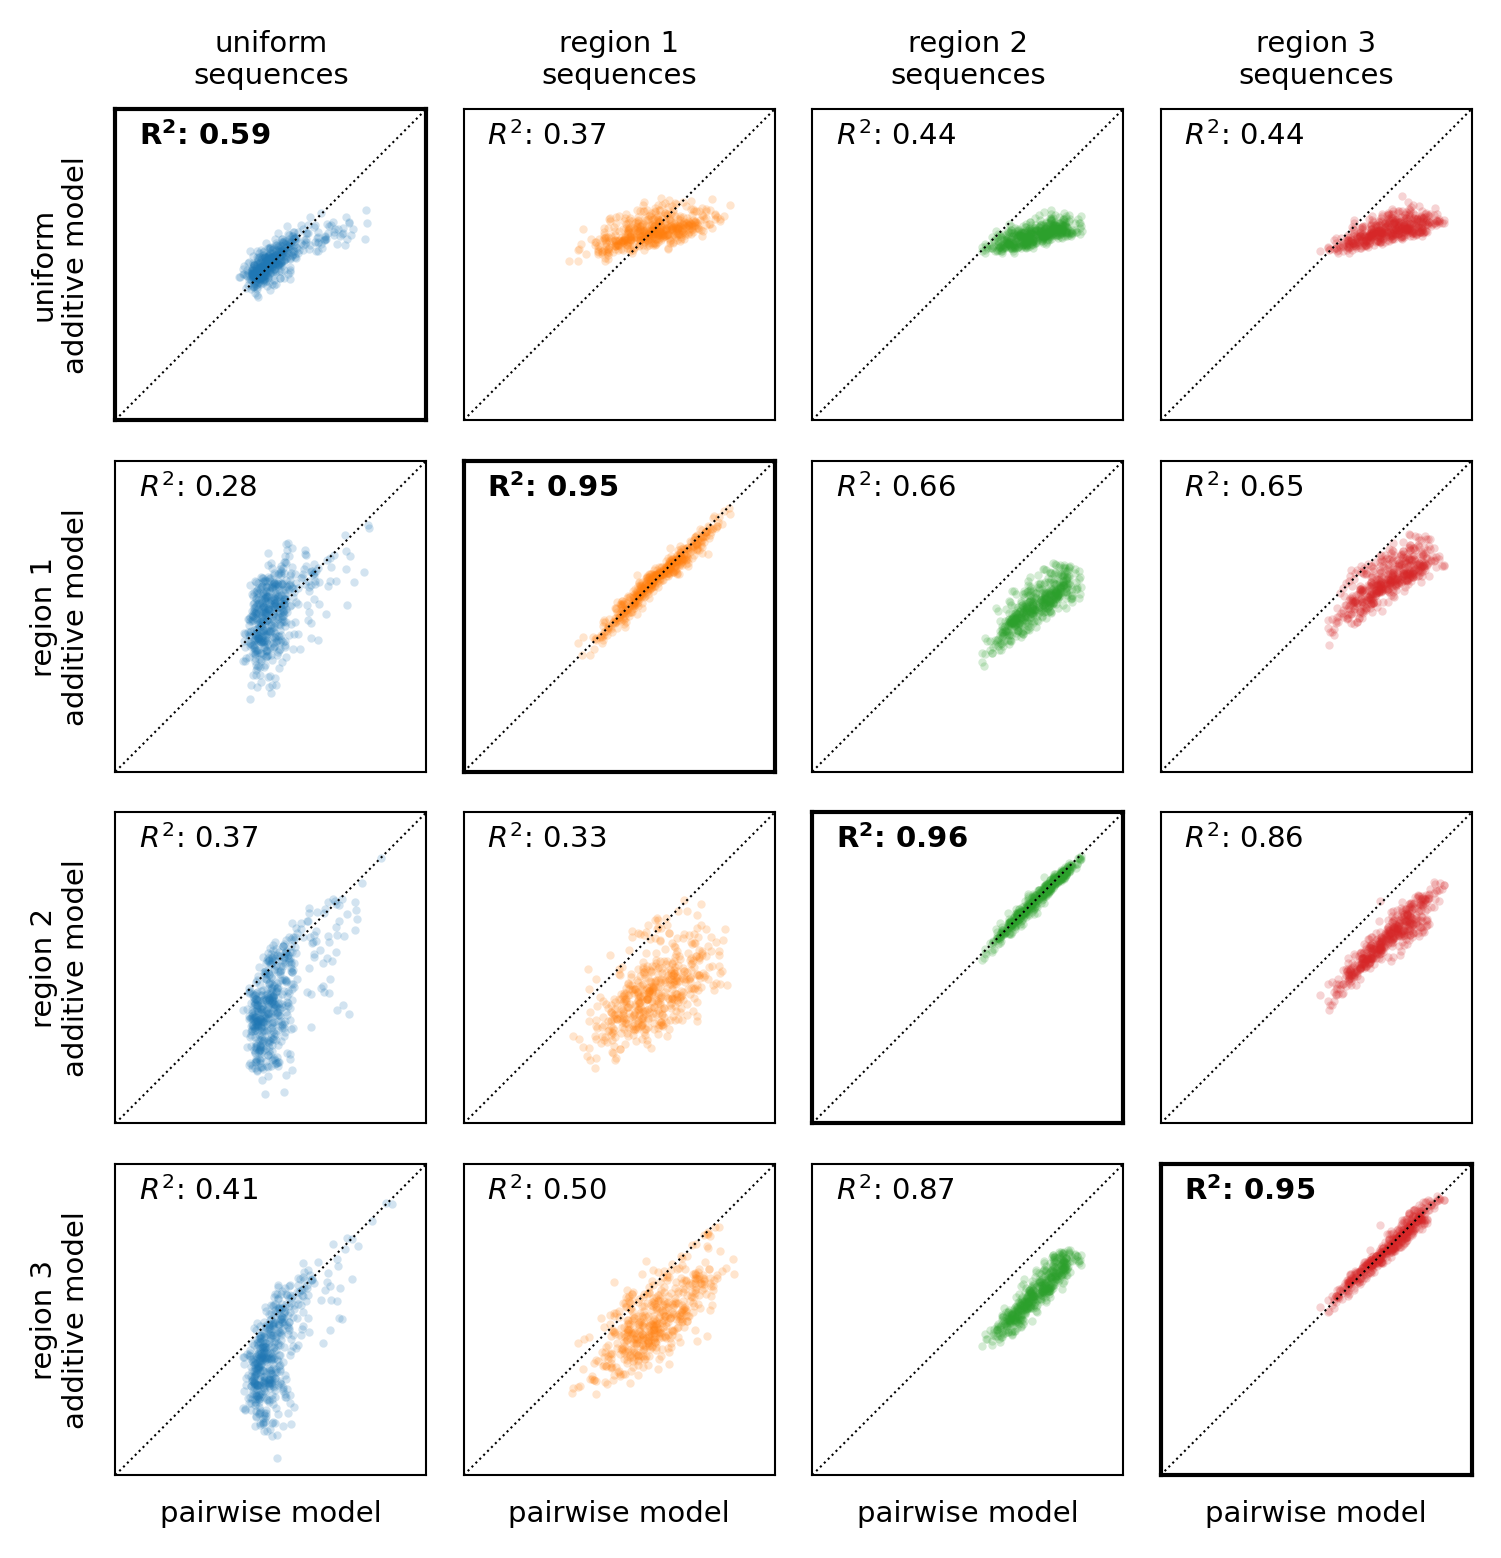

In [25]:
# Plot predictions of additive model in each gauge
fig, axs = plt.subplots(4, 4, figsize=(5,5.2), sharex=True, sharey=True, dpi=300)

colors = ['C0', 'C1', 'C2', 'C3']

gauges = [
    'uniform\nadditive model',
    'region 1\nadditive model',
    'region 2\nadditive model',
    'region 3\nadditive model',
]

seqsets = [
    'uniform',
    'region 1',
    'region 2',
    'region 3'
]

lim = [-15, 5]

# Number of points to plot
M = 500

y_pair = data_df['y_pair'].values
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        color = colors[j]
        y_add = data_df[f'y_add_{i}'].values
        ix = data_df[f'set_{j}'].values
                
        these_y_pair = y_pair[ix]
        these_y_add = y_add[ix]
        if sum(ix) > M:
            ix2 = np.random.choice(sum(ix), M, replace=False)
            these_y_pair = these_y_pair[ix2]
            these_y_add = these_y_add[ix2]
        
        ax.scatter(these_y_pair, these_y_add, 
                   s=4, 
                   alpha=.2,
                   color=color,
                   rasterized=True,
                   linewidth=0,
                   label=seqsets[j])
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(1)
        
        ax.plot(lim,lim, linestyle=':', color='k', linewidth=.5)

        
        if i==j:
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1)
        
        # Compute and show correlation coefficient
        R = np.corrcoef(y_pair[ix], y_add[ix])[0,1]
        fontweight = 'bold' if i==j else 'regular'
        if i==j:
            s=f'$\\mathbf{{R^2}}$: {R**2:.2f} '
        else:
            s=f'$R^2$: {R**2:.2f} '
        ax.text(x=.9*lim[0], 
                y=.85*lim[1],
                s=s,  
                va='top', 
                ha='left', 
                fontsize=7, 
                fontweight=fontweight)
        
        if i==0:
            #ax.legend(loc='lower left')
            ax.set_title(f'{seqsets[j]}\nsequences')
        elif i==3:
            ax.set_xlabel('pairwise model')
    
        if j==0:
            ax.set_ylabel(gauges[i], ha='center', va='bottom')
        
            
plt.tight_layout(pad=1, h_pad=1, w_pad=1)
plt.show()
fig.savefig(f'{out_dir}fig_1.5_ipynb.pdf')